# Assignment 4 - Predicting and understanding viewer engagement with educational videos 

With the accelerating popularity of online educational experiences, the role of online lectures and other educational video continues to increase in scope and importance. Open access educational repositories such as <a href="http://videolectures.net/">videolectures.net</a>, as well as Massive Open Online Courses (MOOCs) on platforms like Coursera, have made access to many thousands of lectures and tutorials an accessible option for millions of people around the world. Yet this impressive volume of content has also led to a challenge in how to find, filter, and match these videos with learners. 

## About the prediction problem

One critical property of a video is engagement: how interesting or "engaging" it is for viewers, so that they decide to keep watching. Engagement is critical for learning, whether the instruction is coming from a video or any other source. There are many ways to define engagement with video, but one common approach is to estimate it by measuring how much of the video a user watches. If the video is not interesting and does not engage a viewer, they will typically abandon it quickly, e.g. only watch 5 or 10% of the total. 

A first step towards providing the best-matching educational content is to understand which features of educational material make it engaging for learners in general. This is where predictive modeling can be applied, via supervised machine learning.The task is to predict how engaging an educational video is likely to be for viewers, based on a set of features extracted from the video's transcript, audio track, hosting site, and other sources.

## About the dataset

We extracted training and test datasets of educational video features from the VLE Dataset put together by researcher Sahan Bulathwela at University College London. 

There are two data files for use in training and validating of the models: train.csv and test.csv. Each row in these two files corresponds to a single educational video, and includes information about diverse properties of the video content as described further below. The target variable is `engagement` which was defined as True if the median percentage of the video watched across all viewers was at least 30%, and False otherwise.

**File descriptions** 
    assets/train.csv - the training set (Use only this data for training your model!)
    assets/test.csv - the test set
<br>engagement'

**Data fields**

train.csv & test.csv:

    title_word_count - the number of words in the title of the video.
    
    document_entropy - a score indicating how varied the topics are covered in the video, based on the transcript. Videos with smaller entropy scores will tend to be more cohesive and more focused on a single topic.
    
    freshness - The number of days elapsed between 01/01/1970 and the lecture published date. Videos that are more recent will have higher freshness values.
    
    easiness - A text difficulty measure applied to the transcript. A lower score indicates more complex language used by the presenter.
    
    fraction_stopword_presence - A stopword is a very common word like 'the' or 'and'. This feature computes the fraction of all words that are stopwords in the video lecture transcript.
    
    speaker_speed - The average speaking rate in words per minute of the presenter in the video.
    
    silent_period_rate - The fraction of time in the lecture video that is silence (no speaking).
    
train.csv only:
    
    engagement - Target label for training. True if learners watched a substantial portion of the video (see description), or False otherwise.
    

## Evaluation

Predictions will be given as the probability that the corresponding video will be engaging to learners.

The evaluation metric for this assignment is the Area Under the ROC Curve (AUC). 
___

For this assignment we will create a function that trains a model to predict significant learner engagement with a video using `train.csv`. Using this model, return a Pandas Series object of length 2309 with the data being the probability that each corresponding video from `test.csv` will be engaging (according to a model learned from the 'engagement' label in the training set), and the video index being in the `id` field.

Example:

    id
       9240    0.401958
       9241    0.105928
       9242    0.018572
                 ...
       9243    0.208567
       9244    0.818759
       9245    0.018528
             ...
       Name: engagement, dtype: float32   

In [4]:
import warnings
warnings.filterwarnings("ignore")

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(0)   

### DATA EXPLORATION

Let's explore the dataset to get some insights before prepare any model (ideally, we should do a data split in the training-test sets, and study only the train data frame to avoid any data leakage).

In [9]:
df= pd.read_csv('train.csv')
df.head()

,id,title_word_count,document_entropy,freshness,easiness,fraction_stopword_presence,normalization_rate,speaker_speed,silent_period_rate,engagement
0,1,9,7.753995,16310,75.583936,0.553664,0.034049,2.997753,0.0,True
1,2,6,8.305269,15410,86.870523,0.584498,0.018763,2.635789,0.0,False
2,3,3,7.965583,15680,81.915968,0.605685,0.030720,2.538095,0.0,False
3,4,9,8.142877,15610,80.148937,0.593664,0.016873,2.259055,0.0,False
4,5,9,8.161250,14920,76.907549,0.581637,0.023412,2.420000,0.0,False


In [3]:
df.dtypes

id                              int64
title_word_count                int64
document_entropy              float64
freshness                       int64
easiness                      float64
fraction_stopword_presence    float64
normalization_rate            float64
speaker_speed                 float64
silent_period_rate            float64
engagement                       bool
dtype: object

False    8342
True      897
Name: engagement, dtype: int64


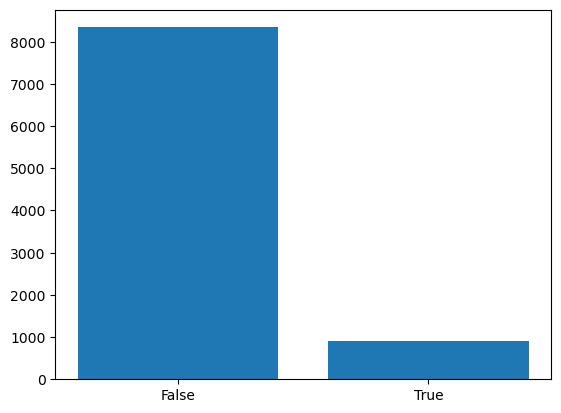

In [4]:
outcome=df['engagement'].value_counts()
plt.bar(outcome.index, outcome, tick_label = outcome.index);
# import seaborn as sb
# sb.countplot(x='engagement',data=train, palette='hls')
print(outcome)

In [5]:
print("Records in the Dataframe :",len(df))

Records in the Dataframe : 9239


Lets chech for null and duplicate values

In [6]:
print("Null values in data:", df.isnull().any(axis=1).sum())
print("Duplicate values in data:", df.duplicated().sum())

Null values in data: 0
Duplicate values in data: 0


To visualize the distribution of our data we are going to use a box plot with the features normalized.

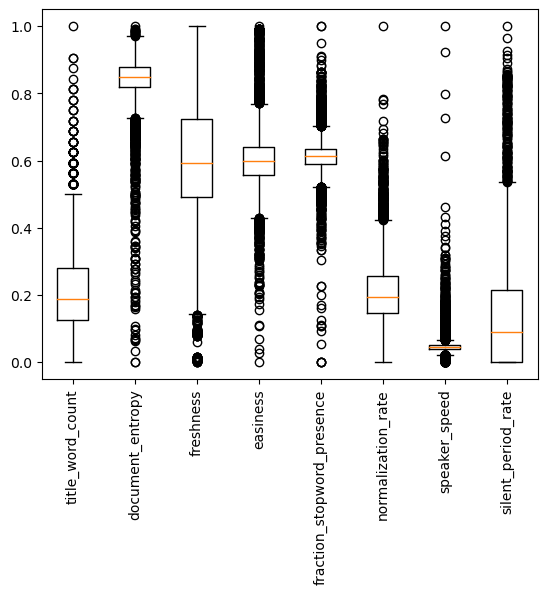

In [7]:
from sklearn.preprocessing import MinMaxScaler
X= df.drop(['id', 'engagement'], axis=1)
X_scaled = MinMaxScaler().fit_transform(X)
labels = X.columns
plt.boxplot(X_scaled);
plt.xticks([1, 2, 3, 4, 5, 6, 7, 8], labels)
plt.xticks(rotation=90);

Lets se the correlation of our features. We can check this with Correlation matrix or  Variance Inflation Factor (VIF) instead.

In [8]:
# scatter = pd.plotting.scatter_matrix(train.drop(['id','engagement'], axis = 1), figsize=(9,9), alpha=0.2);
# for x in scatter.flatten():
#     x.xaxis.label.set_rotation(45)
#     x.yaxis.label.set_rotation(0)
#     x.yaxis.label.set_ha('right')
#     x.set_xticks(())
#     x.set_yticks(())
    
# plt.gcf().subplots_adjust(wspace=0, hspace=0)

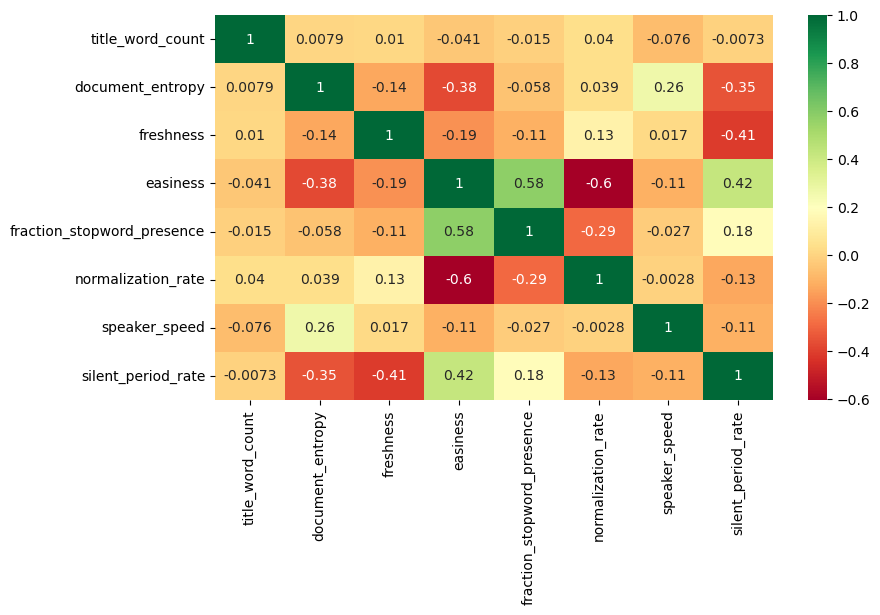

In [9]:
import seaborn as sns
corrMatrix = X.corr()
plt.subplots(figsize=(9, 5))
sns.heatmap(corrMatrix, annot=True, cmap="RdYlGn")
plt.show()

In [10]:
#Use variance inflation factor to identify any significant multi-collinearity
X_cor = X.corr()
VIF = pd.DataFrame(np.linalg.inv(X.corr().values), index = X_cor.index, columns=X_cor.columns)
np.diag(VIF.values)

array([1.00900093, 1.62786502, 1.38665909, 3.20357939, 1.6133965 ,
       1.75272507, 1.08670488, 1.63883523])

## DATA MODELING

Now we will implement multiple machine learning algorithms to categorize the engagment of a video. As you saw from the data exploration we have an unbalanced data set. Therefore we need to have this in consideration to develop our model.

In [10]:
#define X, y data for model
X= df.drop(['id', 'engagement'], axis=1)
y=df['engagement']

In [11]:
#define a fuction for nested cross-validation
#https://ploomber.io/blog/nested-cv/
#https://machinelearningmastery.com/nested-cross-validation-for-machine-learning-with-python/

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
#https://stackoverflow.com/questions/51459406/how-to-apply-standardscaler-in-pipeline-in-scikit-learn-sklearn
from sklearn.model_selection import RandomizedSearchCV, cross_val_score, StratifiedKFold

def nested_cv(model, grid_values, score):
    """run a scaled nested cross validation with 10 folds on the outer cross-validation
    and 3 fold in the inner cross validation"""
    # Create a scaler
    scaler = StandardScaler()
    # Create a pipeline with the scaler and the model
    pipeline = Pipeline([
        ('scaler', scaler),
        ('model', model),
    ])
    # Configure the cross-validation procedure for the inner loop
    cv_inner = StratifiedKFold(n_splits=3, shuffle=True, random_state=0)
    # Define the RandomizedSearchCV for hyperparameter tuning
    search = RandomizedSearchCV(pipeline, grid_values, scoring=score, n_jobs=1, cv=cv_inner, refit=True, random_state=0)
    # Configure the cross-validation procedure for the outer loop
    cv_outer = StratifiedKFold(n_splits=10, shuffle=True, random_state=0)
    # Execute the nested cross-validation
    scores = cross_val_score(search, X, y, scoring=score, cv=cv_outer, n_jobs=-1)
    # Report performance
    print('AUC: %.3f (%.3f)' % (np.mean(scores), np.std(scores)))

In [18]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression()
grid_values = {'model__C': np.arange(0, 100, 0.01)}
score='roc_auc'
nested_cv(model, grid_values, score)

AUC: 0.846 (0.022)


In [279]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
model = LinearDiscriminantAnalysis()
grid_values = {'model__solver': ['svd', 'lsqr'],
              'model__shrinkage': np.arange(0, 1, 0.001)
              }
score='roc_auc'
nested_cv(model, grid_values, score)

AUC: 0.854 (0.021)


In [131]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
model = QuadraticDiscriminantAnalysis()
grid_values = {}
score='roc_auc'
nested_cv(model, grid_values, score)

AUC: 0.838 (0.023)


In [283]:
from sklearn.naive_bayes import GaussianNB
model = GaussianNB()
grid_values = {'model__var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6, 1e-5]}
score='roc_auc'
nested_cv(model, grid_values, score)

AUC: 0.814 (0.026)


In [281]:
from sklearn.neighbors import KNeighborsClassifier
model = KNeighborsClassifier()          
grid_values = {'model__n_neighbors': range(1, 100), 
               'model__weights': ['uniform', 'distance'],
               'model__p': [1, 2]
              }
score='roc_auc'
nested_cv(model, grid_values, score)

AUC: 0.878 (0.020)


In [294]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(random_state=0)      
grid_values = {}
score='roc_auc'
nested_cv(model, grid_values, score)

AUC: 0.885 (0.016)


In [20]:
from sklearn.ensemble import GradientBoostingClassifier
model = GradientBoostingClassifier(random_state=0)  
grid_values = {}
score='roc_auc'
nested_cv(model, grid_values, score)

AUC: 0.886 (0.016)


In [41]:
from sklearn.svm import SVC
model = SVC()         
grid_values = {'model__gamma': np.arange(0, 1, 0.001)}
score='roc_auc'
nested_cv(model, grid_values, score)

AUC: 0.860 (0.023)


As we can observe the Higher value in AUC is 0.886 and it is for the Gradient Boosting Classifier. So we are going to re-train this model on the entire train set, but before try we are going to check is our model is calibrated or we need to make a calibration.

In [12]:
#train model in full data
#split the data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
# Configure the cross-validation procedure
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
#define the model
model = GradientBoostingClassifier(random_state=0)
#define the scaler
scaler = StandardScaler()
#define the pipeline
pipeline = Pipeline([
    ('scaler', scaler),
    ('model', model)
])
# Define the RandomizedSearchCV for hyperparameter tuning
grid_values = {
    'model__n_estimators': range(0, 150),            # Number of trees in the forest
    'model__max_depth': range(0,20),                 # Maximum depth of the trees
    'model__min_samples_split': range(2,10),         # Minimum samples required to split an internal node
    'model__min_samples_leaf': range(1,10)           # Minimum samples required to be at a leaf node
    }
search = RandomizedSearchCV(pipeline, grid_values, cv = kfold, scoring='roc_auc', refit = True, random_state=0)
search.fit(X_train, y_train)

RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=0, shuffle=True),
                   estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                             ('model',
                                              GradientBoostingClassifier(random_state=0))]),
                   param_distributions={'model__max_depth': range(0, 20),
                                        'model__min_samples_leaf': range(1, 10),
                                        'model__min_samples_split': range(2, 10),
                                        'model__n_estimators': range(0, 150)},
                   random_state=0, scoring='roc_auc')

In [13]:
search.best_score_

0.8909209921706246

Lest see the calibration curve of the model.

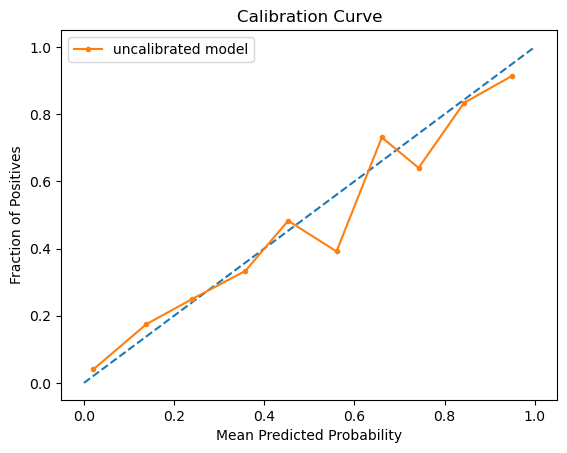

In [22]:
#https://machinelearningmastery.com/calibrated-classification-model-in-scikit-learn/
#https://www.coursera.org/learn/python-machine-learning/lecture/q5f2e/model-calibration-optional

#plot calibration curve
from sklearn.calibration import calibration_curve
# predict probabilities
probs = search.predict_proba(X_test)[:, 1]
# reliability diagram
fop, mpv = calibration_curve(y_test, probs, n_bins=10, normalize=True)
# plot perfectly calibrated
plt.plot([0, 1], [0, 1], linestyle='--')
# plot model reliability
plt.plot(mpv, fop, marker='.', label ='uncalibrated model')
# Add labels and legend
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of Positives')
plt.title('Calibration Curve')
plt.legend();

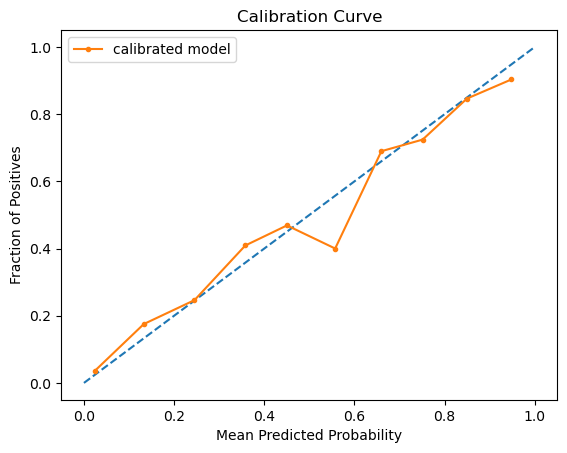

In [24]:
#https://machinelearningmastery.com/probability-calibration-for-imbalanced-classification/
#https://ploomber.io/blog/calibration-curve/

#calibrated the model and plot calibration curve
from sklearn.calibration import CalibratedClassifierCV
calibrated = CalibratedClassifierCV(search, method='sigmoid', cv='prefit')
calibrated.fit(X_test, y_test)
# predict probabilities
probs = calibrated.predict_proba(X_test)[:, 1]
# reliability diagram
fop, mpv = calibration_curve(y_test, probs, n_bins=10, normalize=True)
# plot perfectly calibrated
plt.plot([0, 1], [0, 1], linestyle='--')
# plot calibrated reliability
plt.plot(mpv, fop, marker='.', label ='calibrated model')
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of Positives')
plt.title('Calibration Curve')
plt.legend();

Its seem that our model is good calibrated, and the calibration process is not strictly necessary and dont bring that much improvement . So we are goin to re-train the model with all the data and we are ready to put the model on production.

In [15]:
#get best parameter to use in production model
search.best_params_

{'model__n_estimators': 67,
 'model__min_samples_split': 4,
 'model__min_samples_leaf': 1,
 'model__max_depth': 4}

In [2]:
def engagement_model():
    rec = None
    
    # YOUR CODE HERE
    train= pd.read_csv('train.csv')
    test= pd.read_csv('test.csv')
    
    #Create features and labels dataframes
    X_train= train.drop(['id', 'engagement'], axis=1)
    y_train=train['engagement']
    X_test = test.drop('id', axis=1)
    
    #Feauture scaling
    from sklearn.preprocessing import StandardScaler
    scaler = StandardScaler()
    
    # Define the hyperparameter 
    grid_values = {
        'n_estimators': 67,
        'min_samples_split': 4,
        'min_samples_leaf': 1,
        'max_depth': 4
        }
    #define the model 
    from sklearn.ensemble import GradientBoostingClassifier
    model = GradientBoostingClassifier(**grid_values, random_state=0)
    #define the pipeline
    from sklearn.pipeline import Pipeline
    pipeline = Pipeline([
        ('scaler', scaler),
        ('model', model)
    ])
    #train the model
    pipeline.fit(X_train, y_train)
        
    # make predictions on the test set
    y_test_pred = pipeline.predict_proba(X_test)[:, 1] 
    # create a series with values of y_predicted and ticket_id as index values
    rec = pd.Series(y_test_pred, index=test['id'], name='engagement') 
    return rec

### Extensions

* If this prediction task motivates you to explore further, you can find more details here on the original VLE dataset and others related to video engagement: https://github.com/sahanbull/VLE-Dataset


# APPENDIX A

In addition to a basic evaluation of model accuracy, we've also provided a utility function to visualize which features are most and least contributing to the overall model performance.

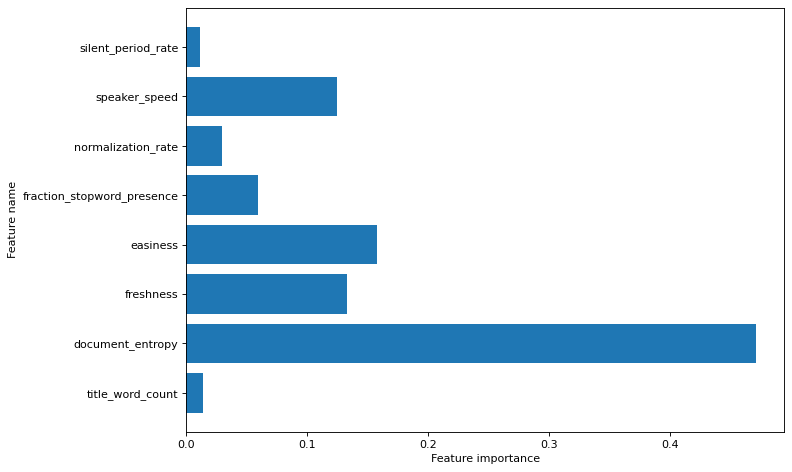

In [7]:
# We need to run the model outside the function

train= pd.read_csv('train.csv')
test= pd.read_csv('test.csv')
#Create features and labels dataframes
X_train= train.drop(['id', 'engagement'], axis=1)
y_train=train['engagement']
X_test = test.drop('id', axis=1)
#Feauture scaling
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
# Define the hyperparameter 
grid_values = {
    'n_estimators': 67,
    'min_samples_split': 4,
    'min_samples_leaf': 1,
    'max_depth': 4
    }
#define the model 
from sklearn.ensemble import GradientBoostingClassifier
model = GradientBoostingClassifier(**grid_values, random_state=0)
#define the pipeline
from sklearn.pipeline import Pipeline
pipeline = Pipeline([
    ('scaler', scaler),
    ('model', model)
])
#train the model
pipeline.fit(X_train, y_train)

 # function for plot feature importance   
def plot_feature_importances(clf, feature_names):
    c_features = len(feature_names)
    plt.barh(range(c_features), clf.feature_importances_)
    plt.xlabel("Feature importance")
    plt.ylabel("Feature name")
    plt.yticks(np.arange(c_features), feature_names)
               
plt.figure(figsize=(10,6),dpi=80)
plot_feature_importances(pipeline.named_steps['model'], X_train.columns)
plt.tight_layout()

# APPENDIX B

Here we are going validate the assumptions of logistic regression (https://github.com/sandipanpaul21/Logistic-regression-in-python/blob/main/07_LR_Assumptions.ipynb or https://pythonfordatascienceorg.wordpress.com/logistic-regression-python/). Logistic regression generally works as a classifier, so the type of logistic regression utilized (binary, multinomial, or ordinal) must match the outcome (dependent) variable in the dataset. **By default, logistic regression assumes that the outcome variable is binary, where the number of outcomes is two.** 

There are only two outcomes as we saw. **We need to check that there be an adequate number of observations for each independent variable in the dataset to avoid creating an overfit model.** One rule of thumb is that the total number of observations should be greater than 500 or there should be 50 records per feature, so we need to have at least 400 records in this dataset.

In [146]:
print("Records in the Dataframe :",len(train))

Records in the Dataframe : 9239


**The observations must be independent of each other** i.e., they should not come from repeated or paired data. This means that each observation is not influenced by or related to the rest of the observations. In particular, we can create the Residual Series plot where we plot the deviance residuals of the logit model against the index numbers of the observation and search for any particular pattern.

In [147]:
# Create a simple logistic regresion model.
from statsmodels.genmod.generalized_linear_model import GLM
from statsmodels.genmod import families
X= train.drop(['id', 'engagement'], axis=1)
y=train['engagement']
logit_model = GLM(y, X, family=families.Binomial())
logit_results = logit_model.fit()

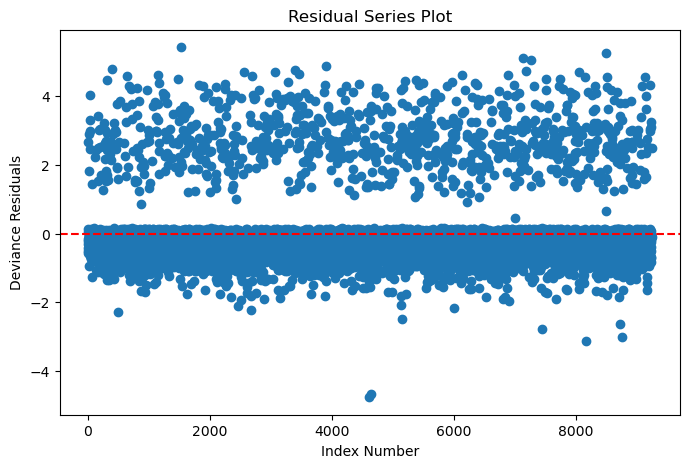

In [148]:
fig = plt.figure(figsize=(8,5))
ax = fig.add_subplot(111, title="Residual Series Plot", xlabel="Index Number",  ylabel="Deviance Residuals")

# Generate residual series plot using standardized deviance residuals
from scipy import stats
ax.scatter(train['id'], stats.zscore(logit_results.resid_deviance))
plt.axhline(y = 0, ls="--", color='red');

 **Another assumption from logistic regression is that there are no highly influential outlier data points, as they distort the outcome and accuracy of the model.** The easiest way to check for outliers is to use a box plot as the one we plot at the beggining. We can also use Cook’s Distance to determine the influence of a data point, and it is calculated based on its residual and leverage. It summarizes the changes in the regression model when that particular (ith) observation is removed.

Threshold for Cook Distance = 0.0004329472886676047
Proportion of data points that are highly influential = 6.5%
Proportion of data points that are highly influential and outliers = 2.0%


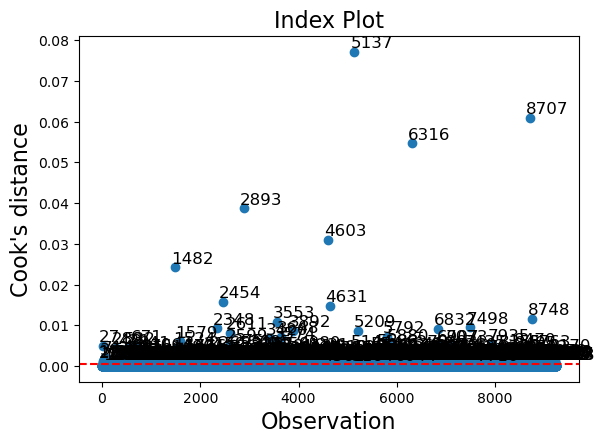

In [149]:
influence = logit_results.get_influence() # Get influence measures
summ_df = influence.summary_frame() # Obtain summary df of influence measures
diagnosis_df = summ_df.loc[:,['cooks_d']] # Filter summary df to Cook distance

diagnosis_df['std_resid'] = stats.zscore(logit_results.resid_pearson) # Append absolute standardized residual values
diagnosis_df['std_resid'] = diagnosis_df.loc[:,'std_resid'].apply(lambda x: np.abs(x))

diagnosis_df.sort_values("cooks_d", ascending=False) # Sort by Cook's Distance

# Set Cook's distance threshold
cook_threshold = 4 / len(X)
print(f"Threshold for Cook Distance = {cook_threshold}")

# Plot influence measures (Cook's distance)
fig = influence.plot_index(y_var="cooks", threshold=cook_threshold)
plt.axhline(y = cook_threshold, ls="--", color='red')
fig.tight_layout(pad=2)

# Find number of observations that exceed Cook's distance threshold
outliers = diagnosis_df[diagnosis_df['cooks_d'] > cook_threshold]
prop_outliers = round(100*(len(outliers) / len(X)),1)
print(f'Proportion of data points that are highly influential = {prop_outliers}%')

# Find number of observations which are BOTH outlier (std dev > 3) and highly influential
extreme = diagnosis_df[(diagnosis_df['cooks_d'] > cook_threshold) & 
                       (diagnosis_df['std_resid'] > 3)]
prop_extreme = round(100*(len(extreme) / len(X)),1)
print(f'Proportion of data points that are highly influential and outliers = {prop_extreme}%')

Accordint to the cook distance the 6.5% of the points are in the outlier zone. **Now we are going to check for Multicollinearity, which  corresponds to a situation where the data contain highly correlated independent variables.** We can check this with Correlation matrix or  Variance Inflation Factor (VIF) instead as we did on the data exploration

In [152]:
#Use variance inflation factor to identify any significant multi-collinearity
X_cor = X.corr()
VIF = pd.DataFrame(np.linalg.inv(X.corr().values), index = X_cor.index, columns=X_cor.columns)
np.diag(VIF.values)

array([1.00900093, 1.62786502, 1.38665909, 3.20357939, 1.6133965 ,
       1.75272507, 1.08670488, 1.63883523])

**One of the critical assumptions of logistic regression is that the relationship between the logit (aka log-odds) of the outcome and each continuous independent variable is linear** . We can check logit linearity is by visually inspecting the scatter plot between each predictor and the logit values, or use the Box-Tidwell transformation (test) to test the linearity in the logit assumption when performing logistic regression.

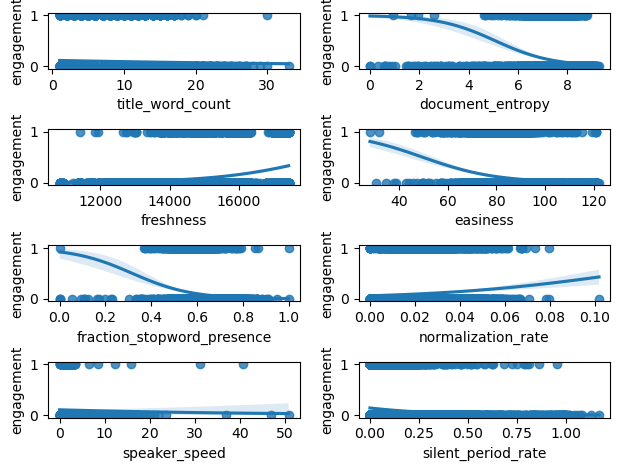

In [153]:
fig = plt.gcf()
regression_data = X.columns
for i in range(1, 9):
    j=i-1
    ax = fig.add_subplot(4, 2, i)
    sns.regplot(x=regression_data[j], y='engagement', data=train, logistic=True)

plt.tight_layout() # Adjust spacing between subplots

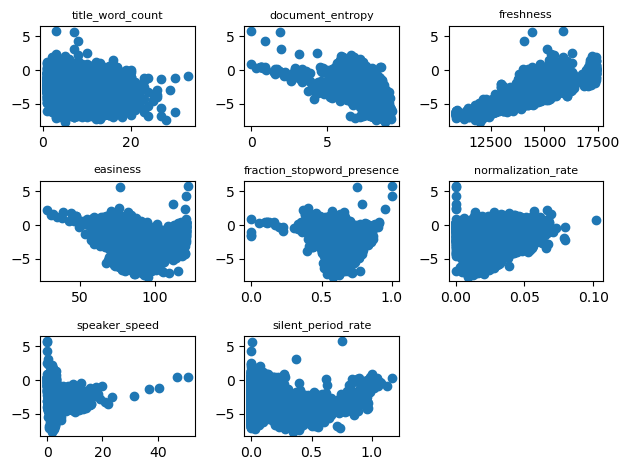

In [154]:
#Run logistic regression on original set of X and y variables
logit_results = GLM(y, X, family=families.Binomial()).fit()
predicted = logit_results.predict(X)
log_odds = np.log(predicted / (1 - predicted)) # Get log odds values

# # Visualize predictor continuous variable vs logit values
regression_data = X.columns
fig = plt.gcf()
for i in range(1, 9):
    j=i-1
    ax = fig.add_subplot(3, 3, i)
    ax.scatter(x = train[regression_data[j]].values, y = log_odds)
    ax.set_title(regression_data[j], fontdict={'fontsize': 8})
    
plt.tight_layout() # Adjust spacing between subplots

# APPENDIX C

As you see we test also an LDA model, here we are going to plot the distributions of the features and the covariance matrix in order to test the assumptions for this models (https://thatdatatho.com/assumption-checking-lda-vs-qda-r-tutorial-2/).

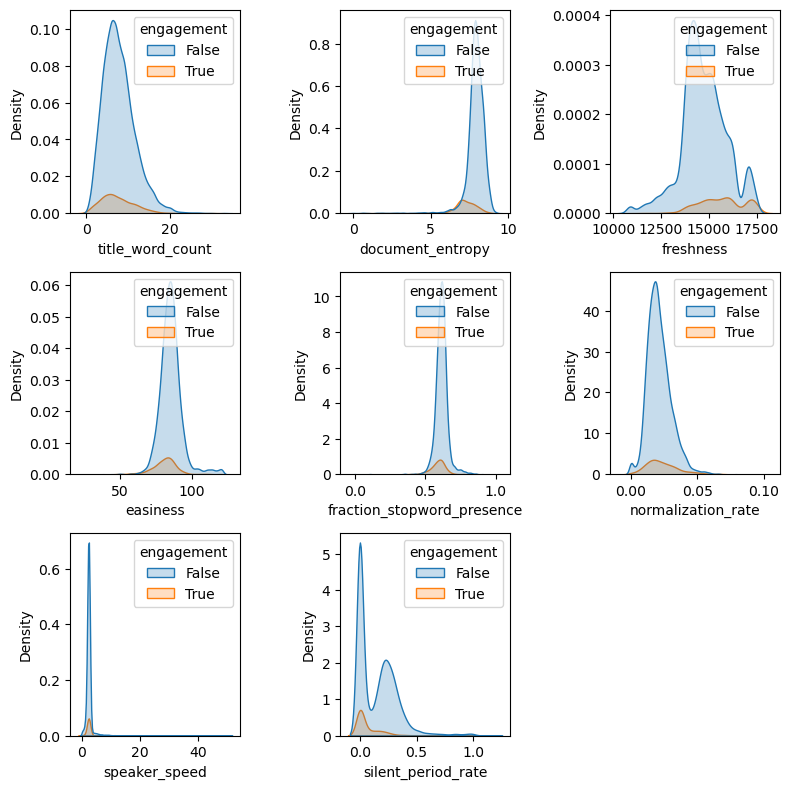

In [132]:
# # Visualize predictor continuous variable 
feature = X.columns
fig = plt.figure(figsize=(8, 8))
for i in range(1, 9):
    j=i-1
    ax = fig.add_subplot(3, 3, i)
    sns.kdeplot(train, x=feature[j], hue='engagement', fill=True)
    
plt.tight_layout() # Adjust spacing between subplots

In [138]:
import pandas as pd

# Assuming df is your DataFrame
data = train.drop(['id'], axis=1)
# Group by the 'engagement' column
grouped = data.groupby('engagement')

# Iterate through each group and calculate the covariance matrix
covariance_matrices = {}
for group, group_data in grouped:
    # Calculate the covariance matrix for the current group
    covariance_matrix = group_data.drop('engagement', axis=1).cov()
    # Store the covariance matrix in the dictionary
    covariance_matrices[group] = covariance_matrix

In [139]:
#print('group False')
covariance_matrices[0]

,title_word_count,document_entropy,freshness,easiness,fraction_stopword_presence,normalization_rate,speaker_speed,silent_period_rate
title_word_count,14.221228,-0.031942,4.468462e+01,-1.444526,-0.003124,0.001692,-0.533284,-0.007349
document_entropy,-0.031942,0.443826,-8.007533e+01,-2.537500,-0.003193,0.000473,0.291266,-0.048535
freshness,44.684618,-80.075330,1.393971e+06,-1643.264610,-5.690403,1.432325,54.477834,-81.454954
easiness,-1.444526,-2.537500,-1.643265e+03,64.410921,0.222740,-0.043804,-1.558836,0.599772
fraction_stopword_presence,-0.003124,-0.003193,-5.690403e+00,0.222740,0.002505,-0.000126,-0.002021,0.001454
normalization_rate,0.001692,0.000473,1.432325e+00,-0.043804,-0.000126,0.000083,0.000014,-0.000212
speaker_speed,-0.533284,0.291266,5.447783e+01,-1.558836,-0.002021,0.000014,2.452094,-0.033157
silent_period_rate,-0.007349,-0.048535,-8.145495e+01,0.599772,0.001454,-0.000212,-0.033157,0.030277


In [140]:
#print('group True')
covariance_matrices[1]

,title_word_count,document_entropy,freshness,easiness,fraction_stopword_presence,normalization_rate,speaker_speed,silent_period_rate
title_word_count,15.190817,0.294902,3.845322e+02,-1.281819,-0.009486,-0.000112,0.209028,-0.007306
document_entropy,0.294902,0.537659,4.170077e+01,-1.216188,-0.005271,-0.000374,0.275162,-0.026627
freshness,384.532245,41.700770,1.324778e+06,-1041.046547,1.146274,0.221085,-129.893498,-66.129923
easiness,-1.281819,-1.216188,-1.041047e+03,95.247073,0.399114,-0.076769,-1.039064,0.362653
fraction_stopword_presence,-0.009486,-0.005271,1.146274e+00,0.399114,0.003909,-0.000262,-0.005092,0.001421
normalization_rate,-0.000112,-0.000374,2.210852e-01,-0.076769,-0.000262,0.000161,-0.000449,-0.000141
speaker_speed,0.209028,0.275162,-1.298935e+02,-1.039064,-0.005092,-0.000449,3.179810,-0.010206
silent_period_rate,-0.007306,-0.026627,-6.612992e+01,0.362653,0.001421,-0.000141,-0.010206,0.018046
